# Reactions
This notebook contains all the steps followed in order to reconcile the existing metabolic reconstruction in CHO cells. It si divided into two parts: **1. Network Reconstruction** and **2. Identification of duplicated reactions**

[1. Network Reconstruction](#reconstruction) <br>
&nbsp;&nbsp;&nbsp;&nbsp;**1.1 Datasets generation and merge**<br>
&nbsp;&nbsp;&nbsp;&nbsp;**1.2 Normalization of the data** <br>
&nbsp;&nbsp;&nbsp;&nbsp;**1.3 Group all the data into a unified dataset** <br>
&nbsp;&nbsp;&nbsp;&nbsp;**1.4 Addition of the Recon3D CHO ortholog GPRs into the reconstruction** <br>
&nbsp;&nbsp;&nbsp;&nbsp;**1.5 Divide the dataset in two to facilitate reading and curation in Google Sheets** <br>

[2. Identification of Duplicated Reactions](#duplicated) <br>
&nbsp;&nbsp;&nbsp;&nbsp;**2.1 Generate the model and identify duplicated reactions**<br>
&nbsp;&nbsp;&nbsp;&nbsp;**2.2 Fix duplicated reactions in the dataset from the list duplicated_reactions obtained above** <br>

[3. Add Database links and Pre-checks to "Rxns" and "Attributes" Sheet](#bigg) <br>
&nbsp;&nbsp;&nbsp;&nbsp;**3.1 Add BiGG and EBI links to the "Rxns" and "Attributes" Sheets**<br>
&nbsp;&nbsp;&nbsp;&nbsp;**3.2 Add a "Pre-check" tag to the Rxns Sheet** <br>

[4. Subsystem Reorganization](#subsystem) <br>
&nbsp;&nbsp;&nbsp;&nbsp;**4.1 Update Transport reactions**<br>
&nbsp;&nbsp;&nbsp;&nbsp;**4.2 Update iCHO1766 Reactions Subsystem**<br>
&nbsp;&nbsp;&nbsp;&nbsp;**4.3 Manual Standarization of Subsystems**<br>
&nbsp;&nbsp;&nbsp;&nbsp;**4.4 Check for differences in the Subsystems of the Reconstrction and Systems datasets** <br>

[5. Manual Curation Metrics](#curation) <br>
&nbsp;&nbsp;&nbsp;&nbsp;**5.1 Calculate the amount of reactions in _max tier_**<br>
&nbsp;&nbsp;&nbsp;&nbsp;**5.2 Calculate the amount of reactions in _medium tier_** <br>
&nbsp;&nbsp;&nbsp;&nbsp;**5.3 Calculate the amount of reactions in _basic tier 1_** <br>
&nbsp;&nbsp;&nbsp;&nbsp;**5.4 Calculate the amount of reactions in _basic tier 2_** <br>
&nbsp;&nbsp;&nbsp;&nbsp;**5.5 Plot a Pie Chart with the amount of reactions in each tier**

## 1. Network Reconstruction <a id='reconstruction'></a>
These include the generation of datasets (1), normalization of the data (2), merging all four reconstructions into a unified dataset (3), compiling the generated reconstruction into a cobra model in order to identify duplicated reactions (4), fixing duplicated reactions using BiGG ID annotation (5), adding Recon3D GPR information (6), and finally dividing the dataset into two different datasets that will be further curated in Google Sheets (7).

In [ ]:
# Libraries import
import pandas as pd
import numpy as np

### 1.1 Datasets generation and merge
Dataset generation from previous reconstructions (CHO_DG44, iCHO1766, iCHO2101, iCHO2291)

In [ ]:
#Read excel files and create the dfs

#Camels CHO_DG44 metabolic reconstruction
camel_df = pd.read_excel('../Data/Reconciliation/datasets/CHO_DG44.xlsx', header = 1)

#Hefzi's iCHO1766 metabolic reconstruction
hefzi_df = pd.read_excel('../Data/Reconciliation/datasets/hefzi_final.xlsx')

#Foudaliha's iCHO2101 metabolic reconstruction
fouladiha_df = pd.read_excel('../Data/Reconciliation/datasets/iCHO2101.xlsx', 'Supplementary Table 10', header = 1)

#Yeo's iCHO2291 metabolic reconstruction
iCHO2291 = pd.read_excel('../Data/Reconciliation/datasets/iCHO2291_final.xlsx')

### 1.2 Normalization of the data
All dataset are normalized into the same shape and format and then combined into one big dataset

In [ ]:
#Standarization of the columns names
camel_df.rename(columns = {'Reaction ID':'Reaction', 'Initial reaction in model':'Reaction Formula', 'Reaction name':'Reaction Name', 'Justification':'Curation Notes'}, inplace = True)
fouladiha_df.rename(columns = {'Abbreviation':'Reaction', 'Description':'Reaction Name', 'Reaction':'Reaction Formula', 'GPR':'GPR_fou'}, inplace = True)

# Addition of tag columns for organizational purposes
camel_df.insert(loc=0, column='cam', value='X')
camel_df.insert(loc=1, column='hef', value=np.nan)
camel_df.insert(loc=2, column='fou', value=np.nan)
camel_df.insert(loc=3, column='yeo', value=np.nan)

hefzi_df.insert(loc=0, column='cam', value=np.nan)
hefzi_df.insert(loc=1, column='hef', value='X')
hefzi_df.insert(loc=2, column='fou', value=np.nan)
hefzi_df.insert(loc=3, column='yeo', value=np.nan)

fouladiha_df.insert(loc=0, column='cam', value=np.nan)
fouladiha_df.insert(loc=1, column='hef', value=np.nan)
fouladiha_df.insert(loc=2, column='fou', value='X')
fouladiha_df.insert(loc=3, column='yeo', value=np.nan)

iCHO2291.insert(loc=0, column='cam', value=np.nan)
iCHO2291.insert(loc=1, column='hef', value=np.nan)
iCHO2291.insert(loc=2, column='fou', value=np.nan)
iCHO2291.insert(loc=3, column='yeo', value='X')

In [ ]:
# Generate cols list with the column names from all datasets
cols = hefzi_df.columns.to_list()+fouladiha_df.columns.to_list()+iCHO2291.columns.to_list()+camel_df.columns.to_list()

# Eliminate repetitive values in the 'cols' list
cols = [cols[i] for i in range(len(cols)) if i == cols.index(cols[i])]

In [ ]:
def add_col(df):
    '''
    This function adds the columns from the cols list 
    that are not present in the df
    '''
    df.columns
    add_col = []
    for col in cols:
        if col not in df.columns:
            add_col.append(col)
    df = df.reindex(columns = df.columns.tolist() + add_col)
    return df

In [ ]:
# Unify columns for all datasets
hefzi_df = add_col(hefzi_df)
fouladiha_df = add_col(fouladiha_df)
iCHO2291 = add_col(iCHO2291)
camel_df = add_col(camel_df)

In [ ]:
# Reorder columns in all datasets the same way
fouladiha_df = fouladiha_df[['cam','hef', 'fou', 'yeo', 'Reaction', 'Reaction Name', 'Reaction Formula', 'GPR_hef','GPR_fou','GPR_yeo', 'Subsystem', 'Genes', 'Protein', 'EC Number', 'Mol wt', 'kcat_forward', 'kcat_backward', 'Reversible','Lower bound', 'Upper bound', 'Objective', 'Curation Notes', 'References', 'Reaction ID Camels Models']]
iCHO2291 = iCHO2291[['cam','hef', 'fou', 'yeo', 'Reaction', 'Reaction Name', 'Reaction Formula', 'GPR_hef','GPR_fou','GPR_yeo', 'Subsystem', 'Genes', 'Protein', 'EC Number', 'Mol wt', 'kcat_forward', 'kcat_backward', 'Reversible','Lower bound', 'Upper bound', 'Objective', 'Curation Notes', 'References', 'Reaction ID Camels Models']]
hefzi_df = hefzi_df[['cam','hef', 'fou', 'yeo', 'Reaction', 'Reaction Name', 'Reaction Formula', 'GPR_hef','GPR_fou','GPR_yeo', 'Subsystem', 'Genes', 'Protein', 'EC Number', 'Mol wt', 'kcat_forward', 'kcat_backward', 'Reversible','Lower bound', 'Upper bound', 'Objective', 'Curation Notes', 'References', 'Reaction ID Camels Models']]
camel_df = camel_df[['cam','hef', 'fou', 'yeo', 'Reaction', 'Reaction Name', 'Reaction Formula', 'GPR_hef','GPR_fou','GPR_yeo', 'Subsystem', 'Genes', 'Protein', 'EC Number', 'Mol wt', 'kcat_forward', 'kcat_backward', 'Reversible','Lower bound', 'Upper bound', 'Objective', 'Curation Notes', 'References', 'Reaction ID Camels Models']]

camel_df['Reaction'] = camel_df['Reaction'].str.strip()

In [ ]:
# Merge all the dfs into a unified df
all_dfs = pd.concat([camel_df, hefzi_df, fouladiha_df, iCHO2291])
all_dfs = all_dfs.reset_index(drop = True)

#Unify reaction names
all_dfs['Reaction'] = all_dfs['Reaction'].str.replace('_cho', '')
all_dfs['Reaction'] = all_dfs['Reaction'].str.replace(r"(e)", "_e_", regex = False)
all_dfs['Reaction'] = all_dfs['Reaction'].str.replace("[", "_")
all_dfs['Reaction'] = all_dfs['Reaction'].str.replace("]", "_")

all_dfs #20940 rows/reactions (many of them repeated)

In [ ]:
# Remove the underscore at the end of some reactions

rxns = []
idx = []

for i,row in all_dfs.iterrows():
    if str(row['Reaction']).endswith('_'):
        s = re.sub('_$', '', row['Reaction'])
        rxns.append(s)
        idx.append(i)
        
all_dfs['Reaction'].update(pd.Series(rxns,index=idx))

### 1.3 Group all the data into a unified dataset
The combined dataset generated above "all_dfs" is grouped by the Reaction BiGG ID to obtain a dataset with unique reaction identifiers

In [ ]:
# Group the data into a unified dataset

all_dfs2 = all_dfs.groupby('Reaction').first()
all_dfs2['Reaction Formula'] = all_dfs2['Reaction Formula'].str.replace('[','_')
all_dfs2['Reaction Formula'] = all_dfs2['Reaction Formula'].str.replace(']','')
all_dfs2['Reaction Formula'] = all_dfs2['Reaction Formula'].str.replace(' => | =>',' --> ')
all_dfs2['Reaction Formula'] = all_dfs2['Reaction Formula'].str.replace(' <-- | <--',' <=> ')
all_dfs2

In [ ]:
# Separate Demand Reaccion into a different df and remove from reconstruction. 
# Keep demand reactions from extracellular space

all_dfs2 = all_dfs2.reset_index()
demand_reactions = pd.DataFrame(columns = all_dfs2.columns)

for index, rxn in all_dfs2.iterrows():
    rxn = rxn['Reaction Formula']
    a,b = re.split('<=>|-->',rxn)
    if (b == '' or b == ' ') and not a.endswith('_e '):
        temp_df = all_dfs2[all_dfs2['Reaction Formula'] == rxn]
        demand_reactions = pd.concat([demand_reactions,temp_df])
        all_dfs2.drop(index, inplace=True)

demand_reactions = demand_reactions.reset_index(drop=True)
demand_reactions.to_excel('../Data/Reconciliation/datasets/demand_reactions.xlsx')
demand_reactions

In [ ]:
all_dfs2 = all_dfs2.reset_index(drop=True)
all_dfs2

### 1.4 Addition of the Recon3D CHO ortholog GPRs into the reconstruction
The information from the dataset generated in the notebook "GPR Annotation" containing all the information from Recon3D GPRS in human and its corresponding CHO orthologs is mapped into our reconstruction

In [ ]:
# Generate a dict with recon3d reactions as keys and the CHO GPRs as values.
recon3d = pd.read_excel('../Data/GPR_Curation/recon3D_chogprs.xlsx')
recon3d_dict = recon3d.set_index('m_reaction')['CHO GPR'].to_dict()
recon3d_dict

In [ ]:
# Map 'recon3d_dict' into the all_dfs3 dataframe
# the reaction IDs should be the same as those in our reconstruction

all_dfs3 = all_dfs2.reset_index()
all_dfs3['GPR_Recon3D'] = all_dfs3['Reaction'].map(recon3d_dict)

### 1.5 Divide the dataset in two to facilitate reading and curation in Google Sheets
The dataset all_dfs3 is divided into two different datasets: all_dfs4 contains mainly all the information regarding GPRs assigned from previous reconstructions. all_dfs5 contains the rest of the attributes in the reconstruction such as EC number, bounds, etc.

In [ ]:
# all_dfs4 contains mainly information of the reactions GPRs
all_dfs4 = all_dfs3[['Reaction', 'Reaction Name', 'Reaction Formula', 'Subsystem', 'GPR_hef', 'GPR_fou', 'GPR_yeo', 'GPR_Recon3D', 'Curation Notes', 'References']]
all_dfs4.insert(8,'GPR_final', '')
all_dfs4.to_excel('../Data/Reconciliation/datasets/all_dfs4.xlsx')
all_dfs4

In [ ]:
# all_dfs5 contains information of the rest of the attributes in our reconstruction
all_dfs5 = all_dfs3[['Reaction', 'Genes', 'Protein', 'EC Number', 'Mol wt', 'kcat_forward', 'kcat_backward', 'Reversible', 'Lower bound', 'Upper bound', 'Objective']]
all_dfs5.to_excel('../Data/Reconciliation/datasets/all_dfs5.xlsx')
all_dfs5

## 2. Identifications of Duplicated Reactions <a id='duplicated'></a>
In this part of the notebook we use the **duplicated_reactions** fucntion from the **utils** module to spot duplicated reactions in our dataset. First we generate a model, using cobprapy, with our dataset, then we apply the **duplicated_reactions** function to the model, and finally we standarize the name of the duplicated reactions according to the nomenclature used in BiGG.

In [ ]:
# Libraries import
import re
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from requests_html import HTMLSession
from tqdm.notebook import tqdm
from cobra import Model, Reaction, Metabolite, util

from utils import duplicated_reactions
from google_sheet import GoogleSheet

### 2.1 Generate the model and identify duplicated reactions
Generation of a cobra model from the **Google Sheet dataset**. This model will be used to identify duplicated reactions from the stoichiometric matrix of the model.

In [ ]:
# Generate the necessary datasets for the identification of the duplicated reactions
KEY_FILE_PATH = 'credentials.json'
SPREADSHEET_ID_v3 = '1MlBXeHIKw8k8fZyXm-sN__AHTRSunJxar_-bqvukZws'

# Initialize the GoogleSheet object
sheet = GoogleSheet(SPREADSHEET_ID_v3, KEY_FILE_PATH)

# Read data from the Google Sheet
sheet_rxns = 'Rxns'
sheet_attributes = 'Attributes'

reactions = sheet.read_google_sheet(sheet_rxns)
rxns_attributes = sheet.read_google_sheet(sheet_attributes)

In [ ]:
##### ----- Create a model from the reactions sheet ----- #####
model = Model("iCHO")
lr = []
for _, row in reactions.iterrows():
    r = Reaction(row['Reaction'])
    lr.append(r)    
model.add_reactions(lr)
model

In [ ]:
##### ----- Add information to each one of the reactions ----- #####
for i,r in enumerate(tqdm(model.reactions)):
    print(r.id)
    r.build_reaction_from_string(reactions['Reaction Formula'][i])
    r.name = reactions['Reaction Name'][i]
    r.subsystem = reactions['Subsystem'][i]
    r.lower_bound = float(rxns_attributes['Lower bound'][i])
    r.upper_bound = float(rxns_attributes['Upper bound'][i])

In [ ]:
duplicated_reactions = duplicated_reactions(model)
duplicated_reactions

### 2.2 Fix duplicated reactions in the dataset from the list duplicated_reactions obtained above
Duplicated reactions are itereated in a for loop and mapped in the original dataset. A request is made in the 
BiGG database http://bigg.ucsd.edu with each of the duplicated reactions. If any of the duplicated reactions is in BiGG, the other reaction automatically changes its name to the one located in Bigg. This way we unifiy the names of our reactions to those in BiGG.

In [ ]:
i = 0
for rxn in tqdm(duplicated_reactions):
    
    session = HTMLSession()
    
    response=session.get('http://bigg.ucsd.edu/models/iCHOv1/reactions/'+reactions['Reaction'][rxn[0]])
    if response.status_code == 200:
        if reactions['Reaction'][rxn[0]] == rxns_attributes['Reaction'][rxn[0]] and reactions.loc[rxn[1], 'Reaction'] == rxns_attributes.loc[rxn[1], 'Reaction']:
            print(f'1 Reaction {reactions.iloc[rxn[1],6]} changed for {reactions.iloc[rxn[0],6]} present in CHOv1 model')
            reactions.loc[rxn[1], 'Reaction'] = reactions['Reaction'][rxn[0]]
            rxns_attributes.loc[rxn[1], 'Reaction'] = rxns_attributes['Reaction'][rxn[0]]
            i += 1
    
    elif response.status_code != 200:
        response=session.get('http://bigg.ucsd.edu/models/iCHOv1/reactions/'+reactions['Reaction'][rxn[1]])
        if response.status_code == 200:
            if reactions['Reaction'][rxn[0]] == rxns_attributes['Reaction'][rxn[0]] and reactions.loc[rxn[1], 'Reaction'] == rxns_attributes.loc[rxn[1], 'Reaction']:
                print(f'2 Reaction {reactions.iloc[rxn[0],6]} changed for {reactions.iloc[rxn[1],6]} present in CHOv1 model')
                reactions.loc[rxn[0], 'Reaction'] = reactions['Reaction'][rxn[1]]
                rxns_attributes.loc[rxn[0], 'Reaction'] = rxns_attributes['Reaction'][rxn[1]]
                i += 1
            
        elif response.status_code != 200:
            response=session.get('http://bigg.ucsd.edu/universal/reactions/'+reactions['Reaction'][rxn[0]])
            if response.status_code == 200:
                if reactions['Reaction'][rxn[0]] == rxns_attributes['Reaction'][rxn[0]] and reactions.loc[rxn[1], 'Reaction'] == rxns_attributes.loc[rxn[1], 'Reaction']:
                    print(f'3 Reaction {reactions.iloc[rxn[1],6]} changed for {reactions.iloc[rxn[0],6]} present BiGG database')
                    reactions.loc[rxn[1], 'Reaction'] = reactions['Reaction'][rxn[0]]
                    rxns_attributes.loc[rxn[1], 'Reaction'] = rxns_attributes['Reaction'][rxn[0]]
                    i += 1
                
            elif response.status_code != 200:
                response=session.get('http://bigg.ucsd.edu/universal/reactions/'+reactions['Reaction'][rxn[1]])
                if response.status_code == 200:
                    if reactions['Reaction'][rxn[0]] == rxns_attributes['Reaction'][rxn[0]] and reactions.loc[rxn[1], 'Reaction'] == rxns_attributes.loc[rxn[1], 'Reaction']:
                        print(f'4 Reaction {reactions.iloc[rxn[0],6]} changed for {reactions.iloc[rxn[1],6]} present BiGG database')
                        reactions.loc[rxn[0], 'Reaction'] = reactions['Reaction'][rxn[1]]
                        rxns_attributes.loc[rxn[0], 'Reaction'] = rxns_attributes['Reaction'][rxn[1]]
                        i += 1
                elif response.status_code != 200:
                    if reactions['Reaction'][rxn[0]] == rxns_attributes['Reaction'][rxn[0]] and reactions.loc[rxn[1], 'Reaction'] == rxns_attributes.loc[rxn[1], 'Reaction']:
                        print(f'5 Reaction {reactions.iloc[rxn[1],6]} changed for {reactions.iloc[rxn[0],6]} not present in Bigg DB')
                        reactions.loc[rxn[1], 'Reaction'] = reactions['Reaction'][rxn[0]]
                        rxns_attributes.loc[rxn[1], 'Reaction'] = rxns_attributes['Reaction'][rxn[0]]
                        i += 1

print(len(duplicated_reactions))
print(i)

In [ ]:
# Store the original column order
column_order_rxns = reactions.columns.tolist()
column_order_att = rxns_attributes.columns.tolist()

# Group by 'BiGG ID' and keep the first non-null value in each group, then reset the index
reactions = reactions.groupby('Reaction').first().reset_index()
rxns_attributes = rxns_attributes.groupby('Reaction').first().reset_index()

# Rearrange the columns to the original order
reactions = reactions[column_order_rxns]
rxns_attributes = rxns_attributes[column_order_att]

In [ ]:
reactions

In [ ]:
##############################################################
#### ---------------------------------------------------- ####
#### ---- Update Rxns and  Attributes Google Sheets ----- ####
#### ---------------------------------------------------- ####
##############################################################
sheet.update_google_sheet(sheet_rxns, reactions)
sheet.update_google_sheet(sheet_attributes, rxns_attributes)
print("Google Sheet updated.")

In [ ]:
# Check that Reactions IDs and formulas are equal in "Rxns" and "Attributes" sheets
reactions = sheet.read_google_sheet(sheet_rxns)
rxns_attributes = sheet.read_google_sheet(sheet_attributes)

rxnsIDseq = list(reactions['Reaction']) == list(rxns_attributes['Reaction'])
if rxnsIDseq:
    print('Reaction IDs in the Rxns and Attributes Sheets are equal\n')
else:
    rxns_sheet_ids = set(list(reactions['Reaction']))
    attr_sheet_ids = set(list(rxns_attributes['Reaction']))
    print(f'Reaction IDs that are in Rxns Sheet and not in Attributes Sheet {rxns_sheet_ids - attr_sheet_ids}\n')
    print(f'Reaction IDs that are in Attributes Sheet and not in Rxns Sheet {attr_sheet_ids - rxns_sheet_ids}\n')

rxnsforseq = list(reactions['Reaction Formula']) == list(rxns_attributes['Reaction Formula'])
if rxnsforseq:
    print('Reaction Formulas in the Rxns and Attributes Sheets are equal')
else:
    rxns_sheet_forms = set(list(reactions['Reaction Formula']))
    attr_sheet_forms = set(list(rxns_attributes['Reaction Formula']))
    print(f'Reaction formulas that are in Rxns Sheet and not in Attributes Sheet {rxns_sheet_forms - attr_sheet_forms}\n')
    print(f'Reaction formulas that are in Attributes Sheet and not in Rxns Sheet {attr_sheet_forms - rxns_sheet_forms}\n')

## 3. Add Database links and Pre-checks to "Rxns" and "Attributes" Sheet <a id='bigg'></a>
This section of the notebook is design to add extra features in the dataset without comprimising previous data.

In [ ]:
# Libraries import
import time
import requests
import pandas as pd
# from requests_html import HTMLSession
from bs4 import BeautifulSoup

from utils import duplicated_reactions
from google_sheet import GoogleSheet

In [ ]:
# Generate the necessary datasets
KEY_FILE_PATH = 'credentials.json'
SPREADSHEET_ID_v3 = '1MlBXeHIKw8k8fZyXm-sN__AHTRSunJxar_-bqvukZws'

# Initialize the GoogleSheet object
sheet = GoogleSheet(SPREADSHEET_ID_v3, KEY_FILE_PATH)

# Read data from the Google Sheet
sheet_rxns = 'Rxns'
sheet_attributes = 'Attributes'

reactions = sheet.read_google_sheet(sheet_rxns)
rxns_attributes = sheet.read_google_sheet(sheet_attributes)

### 3.1 Add BiGG and EBI links to the "Rxns" and "Attributes" Sheets
The functions created **fetch_url** and **extract_ec_numbers** check and retrieve information from the BiGG database. If the queried reaction is in BiGG, the link to the reaction is added to the **BiGG database** column of the **"Rxns" Sheet"**. If the reaction also has an EC Number in the BiGG page, the **extract_ec_numbers** function retrieves this information to be added to the **EC Number** column of the **"Attributes" Sheet**.

In [ ]:
# Define functions

def fetch_url(url, max_retries=5):
    """
    Fetches a given URL and attempts to extract EC (Enzyme Commission)
    numbers associated with reactions from the response.
    
    Parameters:
    - url (str): The URL to fetch.
    - max_retries (int, optional): The maximum number of retries if the request fails. Default is 5.

    Returns:
    - response (requests.models.Response or None): The server's response to the request.
    Returns None if the request fails.
    - ec_numbers (tuple or None): A tuple containing extracted EC numbers as strings and their corresponding links.
    Returns None if no EC numbers are found or if the request fails.

    Note:
    If the server responds with a status code other than 200, both the response and ec_numbers will be set to None.
    """
        
    session = HTMLSession()
    retries = 0
    while retries < max_retries:
        try:
            response = session.get(url)
            if response.status_code == 200:
                ec_numbers = extract_ec_numbers(response)
                return response,ec_numbers
            elif response.status_code != 200:
                response = None
                ec_numbers = None
                return response,ec_numbers
            else:
                retries += 1
        except requests.exceptions.RequestException as e:
            print(f"Error occurred: {e}, retrying...")
            retries += 1
            time.sleep(2)  # wait for 2 seconds before next retry
            response = None
            ec_numbers = None
    return response,ec_numbers

def extract_ec_numbers(response):
    """
    Extracts EC (Enzyme Commission) numbers and their corresponding links from the HTML content
    of a given server response.
    
    Parameters:
    - response (requests.models.Response): The server's response containing the HTML content.

    Returns:
    - ec_numbers_string (str or None): A string containing the extracted EC numbers separated by commas.
    Returns None if no EC numbers are found.
    - ec_links_string (str or None): A string containing the links associated with the extracted EC numbers,
    separated by commas. Returns None if no EC numbers are found.

    Note:
    If the provided response does not contain any EC numbers, this function will print a message
    stating 'No EC Number associated with this rxns in BiGG' and return None for both the EC numbers
    and their links.
    
    """
    
    # Initialize BeautifulSoup with the response content
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all elements containing EC Numbers
    ec_number_elements = soup.find_all('a', href=lambda x: x and 'ec-code' in x)
    
    if len(ec_number_elements) == 0:
        print('No EC Number asociated with this rxns in BiGG')
        return None
    
    elif len(ec_number_elements) > 0:
        # Create a list to hold the EC Numbers and their links
        ec_numbers = []
        ec_links = []

        for element in ec_number_elements:
            # Extract the EC Number from the text of the element
            ec_number = element.text.strip()
            ec_numbers.append(ec_number)
            # Extract the link from the href attribute of the element
            link = element['href']
            ec_links.append(link)
        
        ec_numbers_string = ', '.join(ec_numbers)
        ec_links_string = ', '.join(ec_links)

        return ec_numbers_string, ec_links_string

In [ ]:
# Create df copies to be compared before the update of the dataset
og_reactions = reactions.copy()
og_rxns_attributes = rxns_attributes.copy()

In [ ]:
in_chov1=0
in_bigg=0
not_bigg=0

for i,row in reactions.iterrows():
    rxn=row['Reaction']
    response_esp, ec_data_esp = fetch_url('http://bigg.ucsd.edu/models/iCHOv1/reactions/'+rxn)
    
    if response_esp is not None:
        print(rxn,'in CHOv1')
        reactions.loc[i, 'BiGG database'] = 'http://bigg.ucsd.edu/models/iCHOv1/reactions/'+rxn
        if rxns_attributes.loc[i,'EC Number']=='':
            if ec_data_esp:
                rxns_attributes.loc[i,'EC Number'] = ec_data_esp[0]
                rxns_attributes.loc[i,'EC Number Link'] = ec_data_esp[1]
                print(f'{rxn} EC Number found: {ec_data_esp[0]}, {ec_data_esp[1]}')
        in_chov1+=1
        
    else:
        response_gen, ec_data_gen = fetch_url('http://bigg.ucsd.edu/universal/reactions/'+rxn)
        if response_gen is not None:
            print(rxn,'in Bigg')
            reactions.loc[i, 'BiGG database'] = 'http://bigg.ucsd.edu/universal/reactions/'+rxn
            if rxns_attributes.loc[i,'EC Number']=='':
                if ec_data_gen:
                    rxns_attributes.loc[i,'EC Number'] = ec_data_gen[0]
                    rxns_attributes.loc[i,'EC Number Link'] = ec_data_gen[1]
                    print(f'{rxn} EC Number found: {ec_data_gen[0]}, {ec_data_gen[1]}')
            in_bigg+=1
        else:
            print(rxn,'not in Bigg')
            not_bigg+=1


In [ ]:
print(f'Reactions from CHOv1 reconstruction {in_chov1}')
print(f'Reactions in BiGG database {in_bigg} [not including those in CHOv1)')
print(f'Reactions NOT in BiGG {not_bigg}')

In [ ]:
############################################################
#### -------------------------------------------------- ####
#### ---- Update Rxns and Attributes Google Sheet ----- ####
#### -------------------------------------------------- ####
############################################################
if not og_reactions.equals(reactions):
    sheet.update_google_sheet(sheet_rxns, reactions)
    print("Rxns Sheet updated")
if not og_rxns_attributes.equals(rxns_attributes):
    sheet.update_google_sheet(sheet_attributes, rxns_attributes)
    print("Attributes Sheet updated.")

### 3.2 Add a "Pre-check" tag to the Rxns Sheet
Here we add a "Pre-check" tag to those reactions that don't have a GPR annotation in any of the previous reconstructions. The aim of this is to facilitate the manual curation effort by providing a tag to those reaction that are relatively difficult to curate.

In [ ]:
# Create df copies to be compared before the update of the dataset
og_reactions = reactions.copy()

In [ ]:
# Update reactions df
counter = 0
for i,row in reactions.iterrows():
    curated = row['Curated']
    gpr_hef = row['GPR_hef']
    gpr_fou = row['GPR_fou']
    gpr_yeo = row['GPR_yeo']
    gpr_recon = row['GPR_Recon3D']
    gpr_final = row['GPR_final']
    if (curated == '') and (gpr_hef == '') and (gpr_fou == '') and (gpr_yeo == '') and (gpr_recon == '') and (gpr_final == ''):
        reactions.loc[i,'Curated'] = 'Pre-check'
        reactions.loc[i,'Conf. Score'] = '1'
        counter+=1
        
print(f'Total number of Pre-check reactions:{counter}')

In [ ]:
#############################################
#### ----------------------------------- ####
#### ---- Update Rxns Google Sheet ----- ####
#### ----------------------------------- ####
#############################################

if not og_reactions.equals(reactions): # checks if there has been any update on the original dataset
    sheet.update_google_sheet(sheet_rxns, reactions)
    print("Rxns Sheet updated")

In [ ]:
# Load df containing all the reactions and a "x" mark indicating from which CHO recon each reaction comes from
all_dfs3 = pd.read_excel('../Data/Reconciliation/datasets/all_dfs3.xlsx')
if 'Unnamed: 0' in all_dfs3.columns:
    all_dfs3 = all_dfs3.drop('Unnamed: 0', axis=1)

In [ ]:
# Load df containing all the recon3d reactions
recon3d = pd.read_excel('../Data/Reconciliation/datasets/recon3D_all_reactions.xlsx')
if 'Unnamed: 0' in recon3d.columns:
    recon3d = recon3d.drop('Unnamed: 0', axis=1)

In [ ]:
# Generate listS with all the reactions present in the three CHO reconstructions
rxns_list = []
rxns_hef_list = []
rxns_fou_list = []
rxns_yeo_list = []
for i,row in all_dfs3.iterrows():
    if row['hef']=='X' and row['fou']=='X' and row['yeo']=='X':
        rxns_list.append(row['Reaction'])
    if row['hef']=='X':
        rxns_hef_list.append(row['Reaction'])
    if row['fou']=='X':
        rxns_fou_list.append(row['Reaction'])
    if row['yeo']=='X':
        rxns_yeo_list.append(row['Reaction'])

In [ ]:
# Generate a list with all the reactions present in the three CHO reconstructions
rxns_recon3d_list = list(recon3d['m_reaction'])

In [ ]:
# Update reactions df
counter = 0
for i,row in reactions.iterrows():
    rxn=row['Reaction']
    curated = row['Curated']
    gpr_hef = row['GPR_hef']
    gpr_fou = row['GPR_fou']
    gpr_yeo = row['GPR_yeo']
    gpr_recon = row['GPR_Recon3D']
    gpr_final = row['GPR_final']
    
    if (rxn in rxns_hef_list):
        reactions.loc[i,'iCHO1766'] = 'X'
    else:
        reactions.loc[i,'iCHO1766'] = '-'
    if (rxn in rxns_fou_list):
        reactions.loc[i,'iCH02101'] = 'X'
    else:
        reactions.loc[i,'iCH02101'] = '-'
    if (rxn in rxns_yeo_list):
        reactions.loc[i,'iCHO2291'] = 'X'
    else:
        reactions.loc[i,'iCHO2291'] = '-'
    if (rxn in rxns_recon3d_list):
        reactions.loc[i,'RECON3D'] = 'X'
    else:
        reactions.loc[i,'RECON3D'] = '-'

    if (curated == '') and (rxn in rxns_list) and (gpr_hef == '') and (gpr_fou == '') and (gpr_yeo == '') and (gpr_recon == '') and (gpr_final == ''):
        reactions.loc[i,'Curated'] = 'Pre-check(CHO)'
        reactions.loc[i,'Conf. Score'] = '1'
    elif (curated == '') and (rxn in rxns_hef_list) and (rxn in rxns_recon3d_list) and (gpr_hef == '') and (gpr_fou == '') and (gpr_yeo == '') and (gpr_recon == '') and (gpr_final == ''):
        reactions.loc[i,'Curated'] = 'Pre-check(Hefzi_RECON)'
        reactions.loc[i,'Conf. Score'] = '1'

## 4. Subsystem Reorganization <a id='subsystem'></a>
Update on the subsystem organization of our reconstruction. Subsystems are organized according to Anne's dataset based on the reorganization performed in iCHO1766. Also, each susbsytem is assigned to a larger system conting many subsystems of the same characteristics.

In [1]:
import pickle
import pandas as pd
from google_sheet import GoogleSheet

In [2]:
# Generate the necessary datasets
KEY_FILE_PATH = 'credentials.json'
SPREADSHEET_ID_v3 = '1MlBXeHIKw8k8fZyXm-sN__AHTRSunJxar_-bqvukZws'

# Initialize the GoogleSheet object
sheet = GoogleSheet(SPREADSHEET_ID_v3, KEY_FILE_PATH)

# Read data from the Google Sheet
sheet_rxns = 'Rxns'

reactions = sheet.read_google_sheet(sheet_rxns)
reactions_dc = reactions.copy()

In [3]:
# Subsystems Reorganization Dataset
subsystems = pd.read_excel('../Data/Subsystem/Systems.xlsx', 'iCHO1766_cleaned')

### 4.1 Update Transport reactions
Transport reactions subsystem reorganization is based on the compartment to wich each metabolite is transported to/from.

In [4]:
for i,rxn in reactions_dc.iterrows():
    if rxn['Subsystem'] == 'TRANSPORT':
        if '_e' in rxn['Reaction Formula']:
            print('TRANSPORT, EXTRACELLULAR',rxn['Reaction Formula'])
            reactions_dc.loc[i,'Subsystem'] = 'TRANSPORT, EXTRACELLULAR'
        elif '_m' in rxn['Reaction Formula']:
            print('TRANSPORT, MITOCHONDRIAL',rxn['Reaction Formula'])
            reactions_dc.loc[i,'Subsystem'] = 'TRANSPORT, MITOCHONDRIAL'
        elif '_g' in rxn['Reaction Formula']:
            print('TRANSPORT, GOLGI APPARATUS',rxn['Reaction Formula'])
            reactions_dc.loc[i,'Subsystem'] = 'TRANSPORT, GOLGI APPARATUS'
        elif '_r' in rxn['Reaction Formula']:
            print('TRANSPORT, ENDOPLASMIC RETICULAR',rxn['Reaction Formula'])
            reactions_dc.loc[i,'Subsystem'] = 'TRANSPORT, ENDOPLASMIC RETICULAR'
        elif '_l' in rxn['Reaction Formula']:
            print('TRANSPORT, LYSOSOMAL',rxn['Reaction Formula'])
            reactions_dc.loc[i,'Subsystem'] = 'TRANSPORT, LYSOSOMAL'
        elif '_n' in rxn['Reaction Formula']:
            print('TRANSPORT, NUCLEAR',rxn['Reaction Formula'])
            reactions_dc.loc[i,'Subsystem'] = 'TRANSPORT, NUCLEAR'
        elif '_x' in rxn['Reaction Formula']:
            print('TRANSPORT, PEROXISOMAL',rxn['Reaction Formula'])
            reactions_dc.loc[i,'Subsystem'] = 'TRANSPORT, PEROXISOMAL'
        else:
            raise Exception(f"Compartment unidentified for {rxn['Reaction Formula']}")

rxns_equals = reactions_dc.equals(reactions)
if not rxns_equals:
    sheet.update_google_sheet(sheet_rxns, reactions_dc)
    print("Google Sheet updated.")
elif rxns_equals:
    print("Transport Reactions are up-to-date")

Transport Reactions are up-to-date


In [5]:
# Save previous subsystem organization as a python dict.

#reaction_dict = reactions_dc.set_index('Reaction')['Subsystem'].to_dict()

# Save dictionary as a pickle file
#pickle_file = '../Data/Subsystem/reaction_oldsubsystem_dict.pkl'
#with open(pickle_file, 'wb') as file:
#    pickle.dump(reaction_dict, file)

#pickle_file

### 4.2 Update iCHO1766 Reactions Subsystem
First we update the subsystems of all the reactions extracte from iCHO1766 based on the subsystems annotated in the subsystem dataset.

In [6]:
#Update subsystems in iCHO1766 reactions based on the new reorganization
for i_1,rxn in enumerate(reactions_dc['Reaction']):
    for i_2,rxn2 in enumerate(subsystems['Reaction ID']):
        if str(rxn2) == str(rxn):
            subs1 = str(reactions_dc['Subsystem'][i_1])
            subs2 = str(subsystems['Subsystem'][i_2])
            if subs1 != subs2:
                print('%s Old subsystem: %s --> New subsystem %s' % (rxn, subs1, subs2))
                reactions_dc.at[i_1, 'Subsystem'] = subs2  # Update the subsystem
                
rxns_equals = reactions_dc.equals(reactions)
if not rxns_equals:
    sheet.update_google_sheet(sheet_rxns, reactions_dc)
    print("Google Sheet updated.")
elif rxns_equals:
    print("Subsystem reorganization is up-to-date")

Subsystem reorganization is up-to-date


### 4.3 Manual Standarization of Subsystems
The rest of the subsystems that have not been changed in the previous code are manually standarize in order to comply with the new organization based on the "Systems.xslx" dataset.

In [7]:
# First, we unify all the Fatty Acids subsystems into FATTY ACID METABOLISM
for i,rxn in reactions_dc.iterrows():
    if rxn['Subsystem'] == 'FATTY ACID OXIDATION':
        reactions_dc.loc[i,'Subsystem'] = 'FATTY ACID METABOLISM'
    elif rxn['Subsystem'] == 'FATTY ACID SYNTHESIS':
        reactions_dc.loc[i,'Subsystem'] = 'FATTY ACID METABOLISM'
    elif rxn['Subsystem'] == 'FATTY ACID ELONGATION':
        reactions_dc.loc[i,'Subsystem'] = 'FATTY ACID METABOLISM'

rxns_equals = reactions_dc.equals(reactions)
if not rxns_equals:
    sheet.update_google_sheet(sheet_rxns, reactions_dc)
    print("Google Sheet updated.")
elif rxns_equals:
    print("Fatty Acid reorganization is up-to-date")

Fatty Acid reorganization is up-to-date


In [8]:
# Second, we standarize  'PURINE CATABOLISM and SYNTHESIS', PYRIMIDINE CATABOLISM and SYNTHESIS' in PURINE/PYRIMIDINE METABOLISM
for i,rxn in reactions_dc.iterrows():
    if rxn['Subsystem'] == 'PURINE CATABOLISM':
        reactions_dc.loc[i,'Subsystem'] = 'PURINE METABOLISM'
    elif rxn['Subsystem'] == 'PURINE SYNTHESIS':
        reactions_dc.loc[i,'Subsystem'] = 'PURINE METABOLISM'
    elif rxn['Subsystem'] == 'PYRIMIDINE CATABOLISM':
        reactions_dc.loc[i,'Subsystem'] = 'PYRIMIDINE METABOLISM'
    elif rxn['Subsystem'] == 'PYRIMIDINE SYNTHESIS':
        reactions_dc.loc[i,'Subsystem'] = 'PYRIMIDINE METABOLISM'

rxns_equals = reactions_dc.equals(reactions)
if not rxns_equals:
    sheet.update_google_sheet(sheet_rxns, reactions_dc)
    print("Google Sheet updated.")
elif rxns_equals:
    print("PURINE and PYRIMIDINE reorganization is up-to-date")

PURINE and PYRIMIDINE reorganization is up-to-date


In [9]:
# Third, we standarize 'HEME DEGRADATION' AND 'HEME SYNTHESIS' into 'HEME METABOLISM'
for i,rxn in reactions_dc.iterrows():
    if rxn['Subsystem'] == 'HEME DEGRADATION':
        reactions_dc.loc[i,'Subsystem'] = 'HEME METABOLISM'
    elif rxn['Subsystem'] == 'HEME SYNTHESIS':
        reactions_dc.loc[i,'Subsystem'] = 'HEME METABOLISM'

rxns_equals = reactions_dc.equals(reactions)
if not rxns_equals:
    sheet.update_google_sheet(sheet_rxns, reactions_dc)
    print("Google Sheet updated.")
elif rxns_equals:
    print("HEME reorganization is up-to-date")

HEME reorganization is up-to-date


In [10]:
# Fourth, we change the O-GLYCAN and N-GLYCAN subsystems according to Systems dataset
for i,rxn in reactions_dc.iterrows():
    if rxn['Subsystem'] == 'N-GLYCAN BIOSYNTHESIS':
        reactions_dc.loc[i,'Subsystem'] = 'N-GLYCAN METABOLISM'
    elif rxn['Subsystem'] == 'O-GLYCAN METABOLISM':
        reactions_dc.loc[i,'Subsystem'] = 'O-GLYCAN SYNTHESIS'

rxns_equals = reactions_dc.equals(reactions)
if not rxns_equals:
    sheet.update_google_sheet(sheet_rxns, reactions_dc)
    print("Google Sheet updated.")
elif rxns_equals:
    print("O-GLYCAN and N-GLYCAN reorganization is up-to-date")

O-GLYCAN and N-GLYCAN reorganization is up-to-date


In [11]:
# Fifth, we standarize the 'COA CATABOLISM' and 'COA SYNTHESIS'into 'COA METABOLISM'
for i,rxn in reactions_dc.iterrows():
    if rxn['Subsystem'] == 'COA CATABOLISM':
        reactions_dc.loc[i,'Subsystem'] = 'COA METABOLISM'
    elif rxn['Subsystem'] == 'COA SYNTHESIS':
        reactions_dc.loc[i,'Subsystem'] = 'COA METABOLISM'

rxns_equals = reactions_dc.equals(reactions)
if not rxns_equals:
    sheet.update_google_sheet(sheet_rxns, reactions_dc)
    print("Google Sheet updated.")
elif rxns_equals:
    print("COA reorganization is up-to-date")

COA reorganization is up-to-date


In [12]:
# Sixth, we include 'KERATAN SULFATE DEGRADATION' in 'KERATAN SULFATE METABOLISM'
for i,rxn in reactions_dc.iterrows():
    if rxn['Subsystem'] == 'KERATAN SULFATE DEGRADATION':
        reactions_dc.loc[i,'Subsystem'] = 'KERATAN SULFATE METABOLISM'

rxns_equals = reactions_dc.equals(reactions)
if not rxns_equals:
    sheet.update_google_sheet(sheet_rxns, reactions_dc)
    print("Google Sheet updated.")
elif rxns_equals:
    print("KERATAN SULFATE reorganization is up-to-date")

KERATAN SULFATE reorganization is up-to-date


In [13]:
# Finally, we standarize the BIOMASS AND 'MISCELLANEOUS' subsystems according to the new organization
for i,rxn in reactions_dc.iterrows():
    if rxn['Subsystem'] == 'BIOMASS AND MAINTENANCE FUNCTIONS':
        reactions_dc.loc[i,'Subsystem'] = 'BIOMASS'
    elif rxn['Subsystem'] == 'BIOMASS SYNTHESIS':
        reactions_dc.loc[i,'Subsystem'] = 'BIOMASS'
    elif rxn['Subsystem'] == 'MISCELLANEOUS':
        reactions_dc.loc[i,'Subsystem'] = 'UNASSIGNED'

        
rxns_equals = reactions_dc.equals(reactions)
if not rxns_equals:
    sheet.update_google_sheet(sheet_rxns, reactions_dc)
    print("Google Sheet updated.")
elif rxns_equals:
    print("BIOMASS and 'MISCELLANEOUS' reactions reorganization is up-to-date")

BIOMASS and 'MISCELLANEOUS' reactions reorganization is up-to-date


### 4.4 Check for differences in the Subsystems of the Reconstrction and Systems datasets
Here we check for differences after all the modifications. Some of these differences can be fixed manually and others can be kept as new subsystems.

In [14]:
AR_subsystems = set(subsystems['Subsystem'])

In [15]:
Reconstruction_subsystems = set(reactions_dc['Subsystem'])

In [16]:
shared_subsystems = Reconstruction_subsystems.intersection(AR_subsystems)
print(len(shared_subsystems), shared_subsystems)

101 {'HEPARAN SULFATE DEGRADATION', 'SPHINGOLIPID METABOLISM', 'TRANSPORT, ENDOPLASMIC RETICULAR', 'VITAMIN B12 METABOLISM', 'GLYCINE, SERINE, ALANINE AND THREONINE METABOLISM', 'LIMONENE AND PINENE DEGRADATION', 'NUCLEOTIDE SALVAGE PATHWAY', 'TRANSPORT, NUCLEAR', 'VITAMIN C METABOLISM', 'THIAMINE METABOLISM', 'PURINE METABOLISM', 'UREA CYCLE', 'HISTIDINE METABOLISM', 'PHOSPHATIDYLINOSITOL PHOSPHATE METABOLISM', 'AMINO ACID DERIVATIVE', 'VITAMIN E METABOLISM', 'ARGININE AND PROLINE METABOLISM', 'ANDROGEN AND ESTROGEN SYNTHESIS AND METABOLISM', 'CHONDROITIN SULFATE DEGRADATION', 'CHOLESTEROL METABOLISM', 'PYRIMIDINE METABOLISM', 'D-ALANINE METABOLISM', 'LINOLEATE METABOLISM', 'GLYCOSYLPHOSPHATIDYLINOSITOL (GPI)-ANCHOR BIOSYNTHESIS', 'TRIACYLGLYCEROL SYNTHESIS', 'PROPANOATE METABOLISM', 'ALANINE AND ASPARTATE METABOLISM', 'AMINOSUGAR METABOLISM', 'CYTOCHROME METABOLISM', 'GLUTATHIONE METABOLISM', 'LIPOATE METABOLISM', 'FRUCTOSE AND MANNOSE METABOLISM', 'SQUALENE AND CHOLESTEROL SYNTHESIS

In [17]:
AR_subsystems_unique = AR_subsystems.difference(Reconstruction_subsystems)
Reconstruction_subsystems_unique = Reconstruction_subsystems.difference(AR_subsystems)

In [18]:
Reconstruction_subsystems_unique

{'GLYCAN AND GLYCOSAMINOGLYCAN METABOLISM',
 'GLYCAN AND GLYCOSAMINOGLYCAN METABOLISM\n',
 'NUCLEOTIDE INTERCONVERSION',
 'PEPTIDE METABOLISM',
 'PROTEIN ASSEMBLY',
 'PROTEIN DEGRADATION',
 'PROTEIN MODIFICATION',
 'VITAMIN K METABOLISM'}

In [19]:
AR_subsystems_unique

{'PROTEIN PRODUCTION'}

In [20]:
unique_counter = 0
for index, reaction in reactions.iterrows():
    if reaction['Subsystem'] in Reconstruction_subsystems_unique:
        unique_counter += 1
        print(unique_counter, reaction['Subsystem'], ", ", reaction['Reaction Name'], ", ", reaction['Reaction Formula'])

1 GLYCAN AND GLYCOSAMINOGLYCAN METABOLISM ,  dolichyl-beta-D-mannosyl-phosphate:protein-serine O-D-mannosyltransferase ,  Ser_Thr_r + dolmanp_r --> dolp_r + h_r + mser_r
2 GLYCAN AND GLYCOSAMINOGLYCAN METABOLISM ,  fser transport ,  fser_r --> fser_g
3 GLYCAN AND GLYCOSAMINOGLYCAN METABOLISM ,  Galactoside 2-alpha-L-fucosyltransferase 1 ,  acgalgalacglcgalgluside_cho_g + gdpfuc_g --> acgalfucgalacglcgalgluside_cho_g + gdp_g + h_g
4 GLYCAN AND GLYCOSAMINOGLYCAN METABOLISM ,  beta-N-acetylglucosaminylglycopeptide beta-1,4-galactosyltransferase ,  fn2m2masn_g + udpgal_g --> h_g + lfn2m2masn_g + udp_g
5 GLYCAN AND GLYCOSAMINOGLYCAN METABOLISM ,  beta-N-acetylglucosaminylglycopeptide beta-1,4-galactosyltransferase ,  fnm2masn_g + udpgal_g --> h_g + lfnm2masn_g + udp_g
6 GLYCAN AND GLYCOSAMINOGLYCAN METABOLISM ,  beta-N-acetylglucosaminylglycopeptide beta-1,4-galactosyltransferase ,  nm2masn_g + udpgal_g --> h_g + lnm2masn_g + udp_g
7 GLYCAN AND GLYCOSAMINOGLYCAN METABOLISM ,  beta-N-acetylg

## 5. Manual Curation Metrics <a id='curation'></a>
Here we estimate and classify the amount of curated reactions in each tier of the updated version of the proposed work plan of the reaconstruction: https://docs.google.com/document/d/1C9iJx2F5Om5pTk5607naa9cluA6x8BzC7dqt1ybtg6A/edit

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from google_sheet import GoogleSheet

In [2]:
# Generate the necessary datasets
KEY_FILE_PATH = 'credentials.json'
SPREADSHEET_ID_v3 = '1MlBXeHIKw8k8fZyXm-sN__AHTRSunJxar_-bqvukZws'

# Initialize the GoogleSheet object
sheet = GoogleSheet(SPREADSHEET_ID_v3, KEY_FILE_PATH)

# Read data from the Google Sheet
sheet_rxns = 'Rxns'

reactions = sheet.read_google_sheet(sheet_rxns)
metric_reactions = reactions.copy()

### 5.1 Calculate the amount of reactions in _max tier_
_Max tier_ represents the most complete type of manual curation and it is based in New literature curation

In [3]:
max_tier_counter = 0

for i,r in metric_reactions.iterrows():
    if (r['Curated'] != '') and (r['Curated'] != 'Pre-check') and (r['Curated'] != 'NOT CURATED') and (r['Curated'] != 'basic tier 1 (RxnsWithNotes)') and (r['Curated'] != 'basic tier 1 (Recon3DRxns)') and (r['Curated'] != 'basic tier 2 (AllRecons)') and (r['Curated'] != 'basic tier 2 (Recon3D&CHO)'):
        notes = str(r['Curation Notes']).lower()
        references = str(r['References']).lower()
        if 'rhea' not in notes and 'rhea' not in references:
            max_tier_counter += 1
        
print(max_tier_counter)

3527


### 5.2 Calculate the amount of reactions in _medium tier_
_Medium tier_ represents reactions that have been curated using the new approach basen on the Rheat database

In [4]:
medium_tier_counter = 0

for i,r in metric_reactions.iterrows():
    if (r['Curated'] != '') and (r['Curated'] != 'Pre-check') and (r['Curated'] != 'NOT CURATED') and (r['Curated'] != 'basic tier 1 (RxnsWithNotes)') and (r['Curated'] != 'basic tier 1 (Recon3DRxns)') and (r['Curated'] != 'basic tier 2 (AllRecons)') and (r['Curated'] != 'basic tier 2 (Recon3D&CHO)'):
        notes = str(r['Curation Notes']).lower()
        references = str(r['References']).lower()
        if 'rhea' in notes or 'rhea' in references:
            medium_tier_counter += 1
        
print(medium_tier_counter)

2890


### 5.3 Calculate the amount of reactions in _basic tier 1_
_Basic tier 1_ comprises reactions with spot check of previous curation, Recon 3D reactions - porting of their curation + homology mapping of GPRs, Porting of Hefzi curation note, Acceptance of no-GPR reactions

In [5]:
# Pre-check reactions
pre_check_counter = 0

for i,r in metric_reactions.iterrows():
    if r['Curated'] == 'Pre-check':
        pre_check_counter += 1
        
print(pre_check_counter)

1402


In [6]:
# Reactions not curated with notes
notes_counter = 0

for i, r in metric_reactions.iterrows():
    # Strip leading/trailing whitespace and check if the result is not an empty string
    if (r['Curated'] == '') and isinstance(r['Curation Notes'], str) and r['Curation Notes'].strip() != '':
        notes_counter += 1
        metric_reactions.loc[i,'Curated'] = 'basic tier 1 (RxnsWithNotes)'
    elif r['Curated'] == 'basic tier 1 (RxnsWithNotes)':
        notes_counter += 1

print(notes_counter)

1018


In [7]:
# Reactions extracted from Recon 3D without notes
recon3d_counter = 0

for i, r in metric_reactions.iterrows():
    if (r['RECON3D'] == 'X') and (r['iCHO1766'] == '-') and (r['iCH02101'] == '-') and (r['iCHO2291'] == '-'):
        # Check if 'Curated' is empty or only contains whitespace
        if pd.isnull(r['Curated']) or (isinstance(r['Curated'], str) and r['Curated'].strip() == ''):
            # Check if 'Curation Notes' is empty or only contains whitespace
            if pd.isnull(r['Curation Notes']) or (isinstance(r['Curation Notes'], str) and r['Curation Notes'].strip() == ''):
                recon3d_counter += 1
                metric_reactions.loc[i,'Curated'] = 'basic tier 1 (Recon3DRxns)'
        elif r['Curated'] == 'basic tier 1 (Recon3DRxns)':
            recon3d_counter += 1
                

print(recon3d_counter)

455


### 5.4 Calculate the amount of reactions in _basic tier 2_
_Basic tier 2_ is divided in two categories: 
1) Reactions with consistent reaction annotation in all the reconstructions. 
2) Reactions with consistent annotation in Recon3D and at least one CHO reconstruction.

In [8]:
# Reactions with consistent reaction annotation in all the reconstructions.
basictier2_allrecons_counter = 0
basictier2_allrecons_list = []

for i, r in metric_reactions.iterrows():
    if (r['RECON3D'] == 'X') and (r['iCHO1766'] == 'X') and (r['iCH02101'] == 'X') and (r['iCHO2291'] == 'X'):
        # Check if 'Curated' is empty or only contains whitespace
        if pd.isnull(r['Curated']) or (isinstance(r['Curated'], str) and r['Curated'].strip() == ''):
            # Check if 'Curation Notes' is empty or only contains whitespace
            if pd.isnull(r['Curation Notes']) or (isinstance(r['Curation Notes'], str) and r['Curation Notes'].strip() == ''):
                basictier2_allrecons_counter += 1
                basictier2_allrecons_list.append(r['Reaction'])
                metric_reactions.loc[i,'Curated'] = 'basic tier 2 (AllRecons)'
        elif r['Curated'] == 'basic tier 2 (AllRecons)':
            basictier2_allrecons_list.append(r['Reaction'])
            basictier2_allrecons_counter += 1
            
print(basictier2_allrecons_counter)

418


In [9]:
# Reactions with consistent annotation in Recon3D and at least one CHO reconstruction.
basictier2_recon3d_counter = 0

for i, r in metric_reactions.iterrows():
    if (r['RECON3D'] == 'X') and ((r['iCHO1766'] == 'X') or (r['iCH02101'] == 'X') or (r['iCHO2291'] == 'X')):
        # Check if 'Curated' is empty or only contains whitespace
        if pd.isnull(r['Curated']) or (isinstance(r['Curated'], str) and r['Curated'].strip() == ''):
            # Check if 'Curation Notes' is empty or only contains whitespace
            if pd.isnull(r['Curation Notes']) or (isinstance(r['Curation Notes'], str) and r['Curation Notes'].strip() == ''):
                if r['Reaction'] not in basictier2_allrecons_list:
                    basictier2_recon3d_counter += 1
                    metric_reactions.loc[i,'Curated'] = 'basic tier 2 (Recon3D&CHO)'
        elif r['Curated'] == 'basic tier 2 (Recon3D&CHO)':
            basictier2_recon3d_counter += 1
            
print(basictier2_recon3d_counter)

206


### 5.5 Plot a Pie Chart with the amount of reactions in each tier
_Basic tier 2_ represents reactions with consistent GPR annotation in all the reconstructions

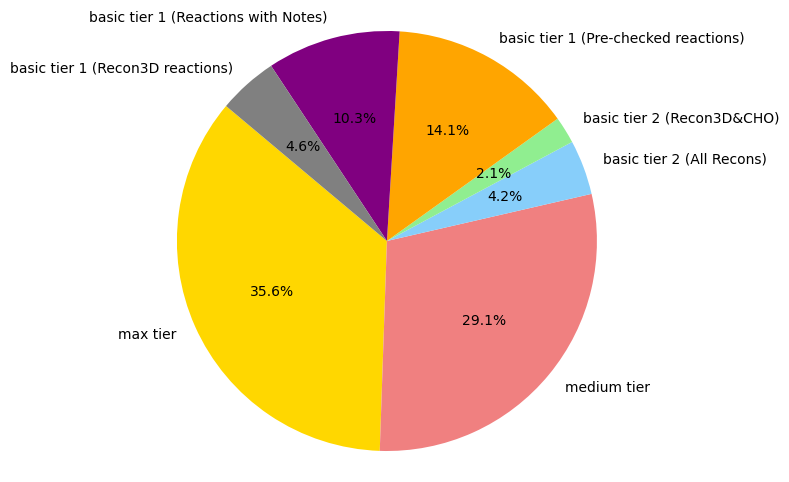

In [13]:
# Calculate the number of reactions that are not curated
not_curated = i - (max_tier_counter + medium_tier_counter + basictier2_allrecons_counter + basictier2_recon3d_counter + pre_check_counter + notes_counter + recon3d_counter)

if not_curated > 0:
    # Labels for the pie chart
    labels = ['max tier', 'medium tier', 'basic tier 2 (All Recons)', 'basic tier 2 (Recon3D&CHO)', 'basic tier 1 (Pre-checked reactions)', 'basic tier 1 (Reactions with Notes)', 'basic tier 1 (Recon3D reactions)', 'Not curated']

    # Sizes for each segment of the pie chart
    sizes = [max_tier_counter, medium_tier_counter, basictier2_allrecons_counter, basictier2_recon3d_counter, pre_check_counter, notes_counter, recon3d_counter, not_curated]

    # Colors for each segment
    colors = ['gold', 'lightcoral', 'lightskyblue', 'lightgreen', 'orange', 'purple', 'grey', 'red']

    # Exploding the 1st slice (i.e., 'max tier')
    explode = (0, 0, 0, 0, 0, 0, 0, 0)  # Make sure this matches the number of entries in 'sizes'
elif not_curated <= 0:
    # Labels for the pie chart
    labels = ['max tier', 'medium tier', 'basic tier 2 (All Recons)', 'basic tier 2 (Recon3D&CHO)', 'basic tier 1 (Pre-checked reactions)', 'basic tier 1 (Reactions with Notes)', 'basic tier 1 (Recon3D reactions)']

    # Sizes for each segment of the pie chart
    sizes = [max_tier_counter, medium_tier_counter, basictier2_allrecons_counter, basictier2_recon3d_counter, pre_check_counter, notes_counter, recon3d_counter]

    # Colors for each segment
    colors = ['gold', 'lightcoral', 'lightskyblue', 'lightgreen', 'orange', 'purple', 'grey']

    # Exploding the 1st slice (i.e., 'max tier')
    explode = (0, 0, 0, 0, 0, 0, 0)  # Make sure this matches the number of entries in 'sizes'

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig('../Comparison/manual_curation_piechart.png', dpi=300)  
plt.show()

In [ ]:
#############################################
#### ----------------------------------- ####
#### ---- Update Rxns Google Sheet ----- ####
#### ----------------------------------- ####
#############################################

if not metric_reactions.equals(reactions): # checks if there has been any update on the original dataset
    sheet.update_google_sheet(sheet_rxns, metric_reactions)
    print("Rxns Sheet updated")